In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


Introduction

Some questions to be answered:
- What are the main predictors for house pricing?
- What is more important on pricing, having big area for housing or just being in better neighborhood?
- Is quality of the house alone more important than having nice garages or basements?
- There are some features that can be modified and depends on the building but there are some other features like cannot be changed like location of the house, which group is effecting house prices?
- Is it possible to predict the price of a house with the training data provided using machine learning techniques?
- What can predictions achieve with different approaches?
- If stack and blend the models, can get more regularized results?

In [2]:
%pip install --upgrade scikit-learn 

# Did this to use latest regressors from sklearn...

     |████████████████████████████████| 24.8 MB 2.0 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Loading neccesary packages:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

#

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#

import warnings
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

Meeting the data

Start by loading the data and taking first look on it as usual.

In [4]:
# Loading datasets.

train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [7]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [8]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

In [9]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [10]:
test.describe()

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1232.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    22.376841   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    58.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    67.000000   9399.000000     6.000000   
75%    2554.500000    70.000000    80.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1459.000000  1459.000000   1459.000000  1444.000000  1458.000000   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704   
std       1.113740    30.390071     21.130467   177.625900   455.268042   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1992.000000     0.000000   350.500000   
75%       6.000000  2001.000000   2004.000000   164.000000   753.500000   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1458.000000  1458.000000  1458.000000  1459.000000  1459.000000   
mean     52.619342   554.294925  1046.117970  1156.534613   325.967786   
std     176.753926   437.260486   442.898624   398.165820   420.610226   
min       0.000000     0.000000     0.000000   407.000000     0.000000   
25%       0.000000   219.250000   784.000000   873.500000     0.000000   
50%       0.000000   460.000000   988.000000  1079.000000     0.000000   
75%       0.000000   797.750000  1305.000000  1382.500000   676.000000   
max    1526.000000  2140.000000  5095.000000  5095.000000  1862.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1459.000000  1459.000000   1457.000000   1457.000000  1459.000000   
mean       3.543523  1486.045922      0.434454      0.065202     1.570939   
std       44.043251   485.566099      0.530648      0.252468     0.555190   
min        0.000000   407.000000      0.000000      0.000000     0.000000   
25%        0.000000  1117.500000      0.000000      0.000000     1.000000   
50%        0.000000  1432.000000      0.000000      0.000000     2.000000   
75%        0.000000  1721.000000      1.000000      0.000000     2.000000   
max     1064.000000  5095.000000      3.000000      2.000000     4.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
count  1459.000000   1459.000000   1459.000000   1459.000000  1459.00000   
mean      0.377656      2.854010      1.042495      6.385195     0.58122   
std       0.503017      0.829788      0.208472      1.508895     0.64742   
min       0.000000      0.000000      0.000000      3.000000     0.00000   
25%       0.000000      2.000000      1.000000      5.000000     0.00000   
50%       0.000000      3.000000      1.000000      6.000000     0.00000   
75%       1.000000      3.000000      1.000000      7.000000     1.00000   
max       2.000000      6.000000      2.000000     15.000000     4.00000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1381.000000  1458.000000  1458.000000  1459.000000  1459.000000   
mean   1977.721217     1.766118   472.768861    93.174777    48.313914   
std      26.431175     0.775945   217.048611   127.744882    68.883364   
min    1895.000000     0.000000     0.000000     0.000000     0.000000   
25%    1959.000000     1.000000   318.000000     0.000000     0.000000   
50%    1979.000000     2.000000   480.000000     0.000000    28.000000   
75%    2002.000000     2.000000   576.000000   168.000000    72.000000   
max    2207.000000     5.0

Id column looks useless, can safely drop it from both. 
Save target (SalePrice) on different variable so can use it in future.

In [11]:
# Dropping unnecessary Id column.

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [12]:
# Backing up target variables and dropping them from train data.

y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

Analysis Time

Start with basic correlation table here. Dropped the top part since it's just mirror of the other part below. With this table can understand some linear relations between different features.

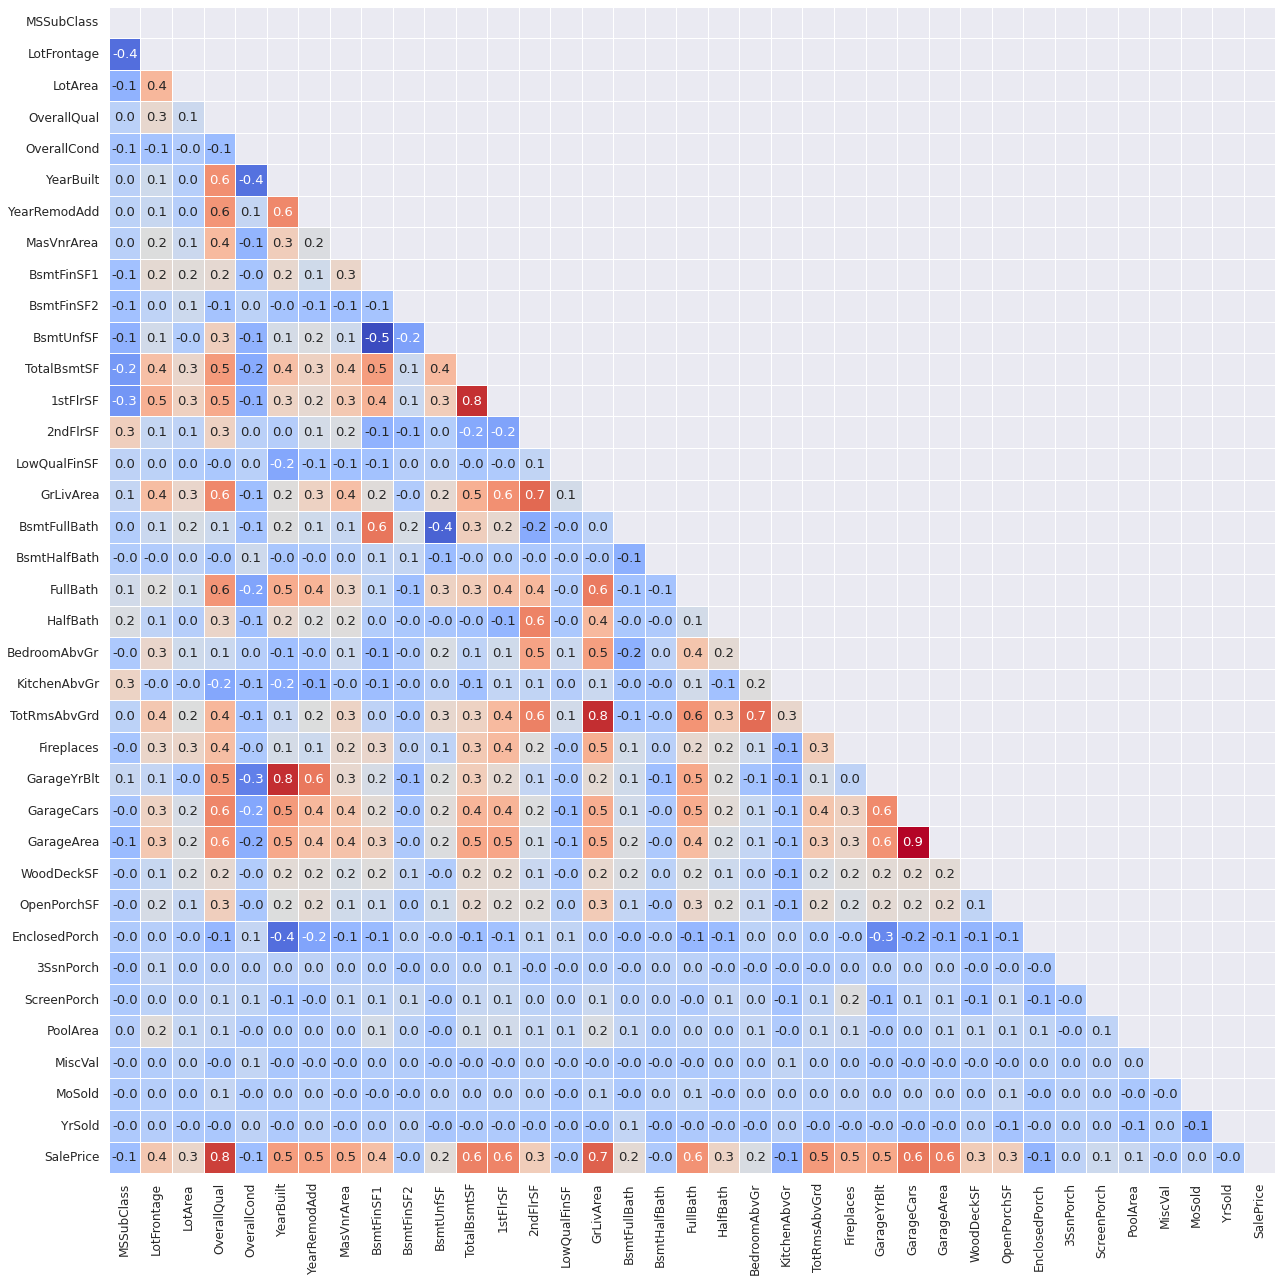

In [13]:
# Display numerical correlations (pearson) between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

Merge the datasets here before start editing it so don't have to do these operations twice. Let's call it features since it has features only. So data has 2919 observations and 79 features to begin with...

In [14]:
# Merging train test features for engineering.

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2919, 79)


Missing Data

First of all need detect missing values. So let's list missing values and visualize them:

In [15]:
def missing_percentage(df):
    
    """A function for returning missing ratios."""
    
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

If look at the data description, can see that most of these missing data actually not missing, it's just means house doesn't have that specific feature, can fix that easily...

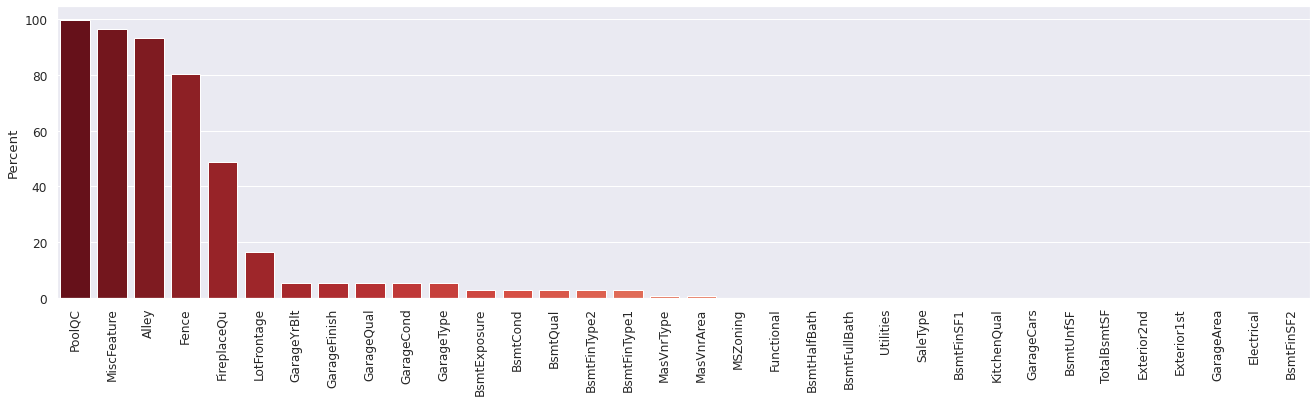

In [16]:
# Checking 'NaN' values.

missing = missing_percentage(features)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

This is how gonna fix most of the missing data:

1. First fill the NaN's in the columns where they mean 'None' so gonna replace them with that;
2. Then fill numerical columns where missing values indicating there is no parent feature to measure, so replace them with 0's;
3. Even with these there are some actual missing data, by checking general trends of these features can fill them with most frequent value (with mode);
4. MSZoning part is little bit tricky, choose to fill them with most common type of the related MSSubClass type. It's not perfect but at least decrease randomness a little bit;
5. Again fill the Lot Frontage with similar approach.

In [17]:
# List of 'NaN' including columns where NaN's mean none.

none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

# List of 'NaN' including columns where NaN's mean 0.

zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of 'NaN' including columns where NaN's actually missing gonna replaced with mode.

freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]

# Filling the list of columns above with appropriate values:

for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

In [18]:
# Filling 'MSZoning' according to MSSubClass.

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

In [19]:
# Filling 'LotFrontage' according to Neighborhood.

features['LotFrontage'] = features.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [20]:
# Features which numerical on data but should be treated as category:

features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

Feature Engineering

Start with grouping some values, these values are really rare and they can not add much, so if they appear less than 10 times in observations they get into 'Other' group.

In [21]:
# Transforming rare values(less than 10) into one group.

others = [
    'Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType'
]

for col in others:
    mask = features[col].isin(
        features[col].value_counts()[features[col].value_counts() < 10].index)
    features[col][mask] = 'Other'

In [22]:
def srt_box(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

Categorical Data

Let's see relations between categorical data and sale price. Boxplots seems decent way to inspect this type of relation. Going to sort them by the median value of that group so can see the importances in descending order.

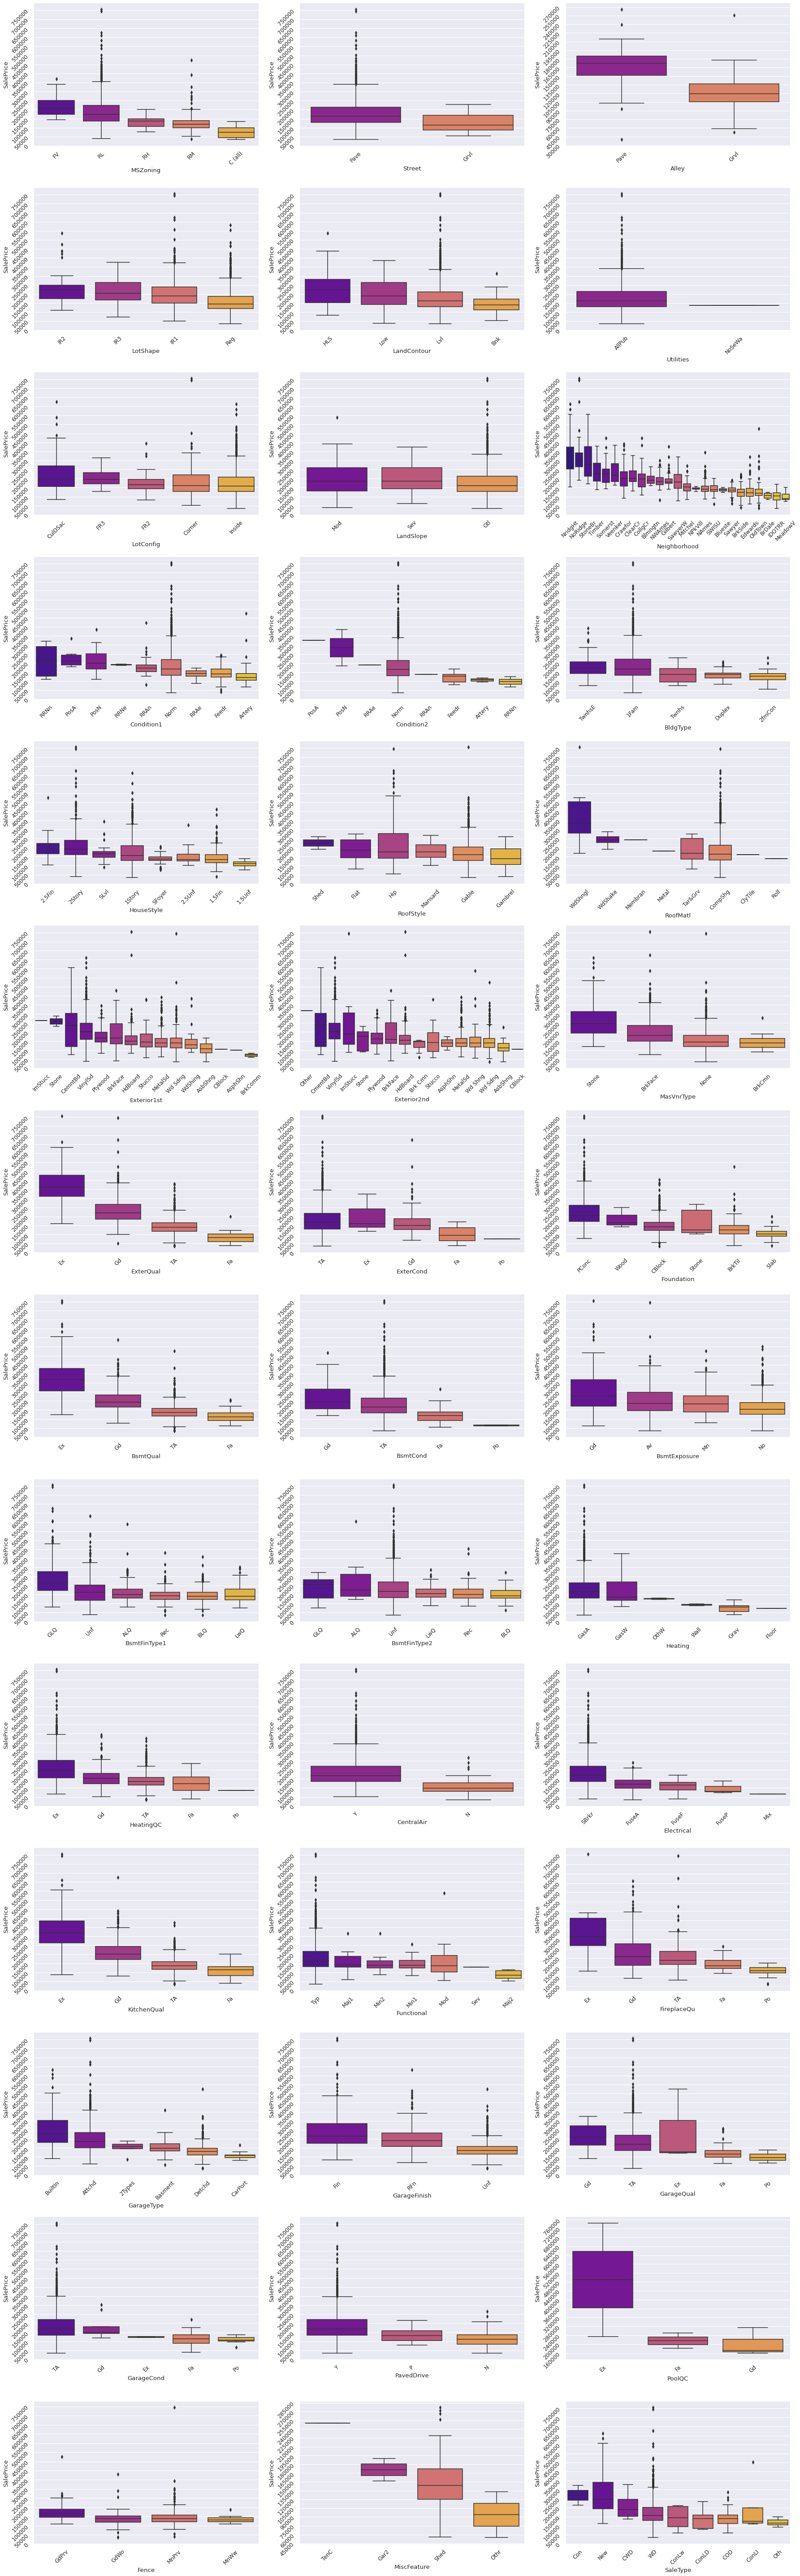

In [23]:
# Displaying sale prices vs. categorical values:

srt_box('SalePrice', train)

Done with categorical data inspecting, let's convert some of these categories to numerical ones, especially the ones where related to quality of the specific features.

In [24]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype(
    'int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

Numeric Data

There are many numeric features the inspect, one of the best ways to see how they effect sale prices is scatter plots (polynomial regression lines to see general trend). With this way can understand the numerical values and their importance on sale price, also it's really helpful to spot outliers.

In [25]:
# Plotting numerical features with polynomial order to detect outliers by eye.

def srt_reg(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

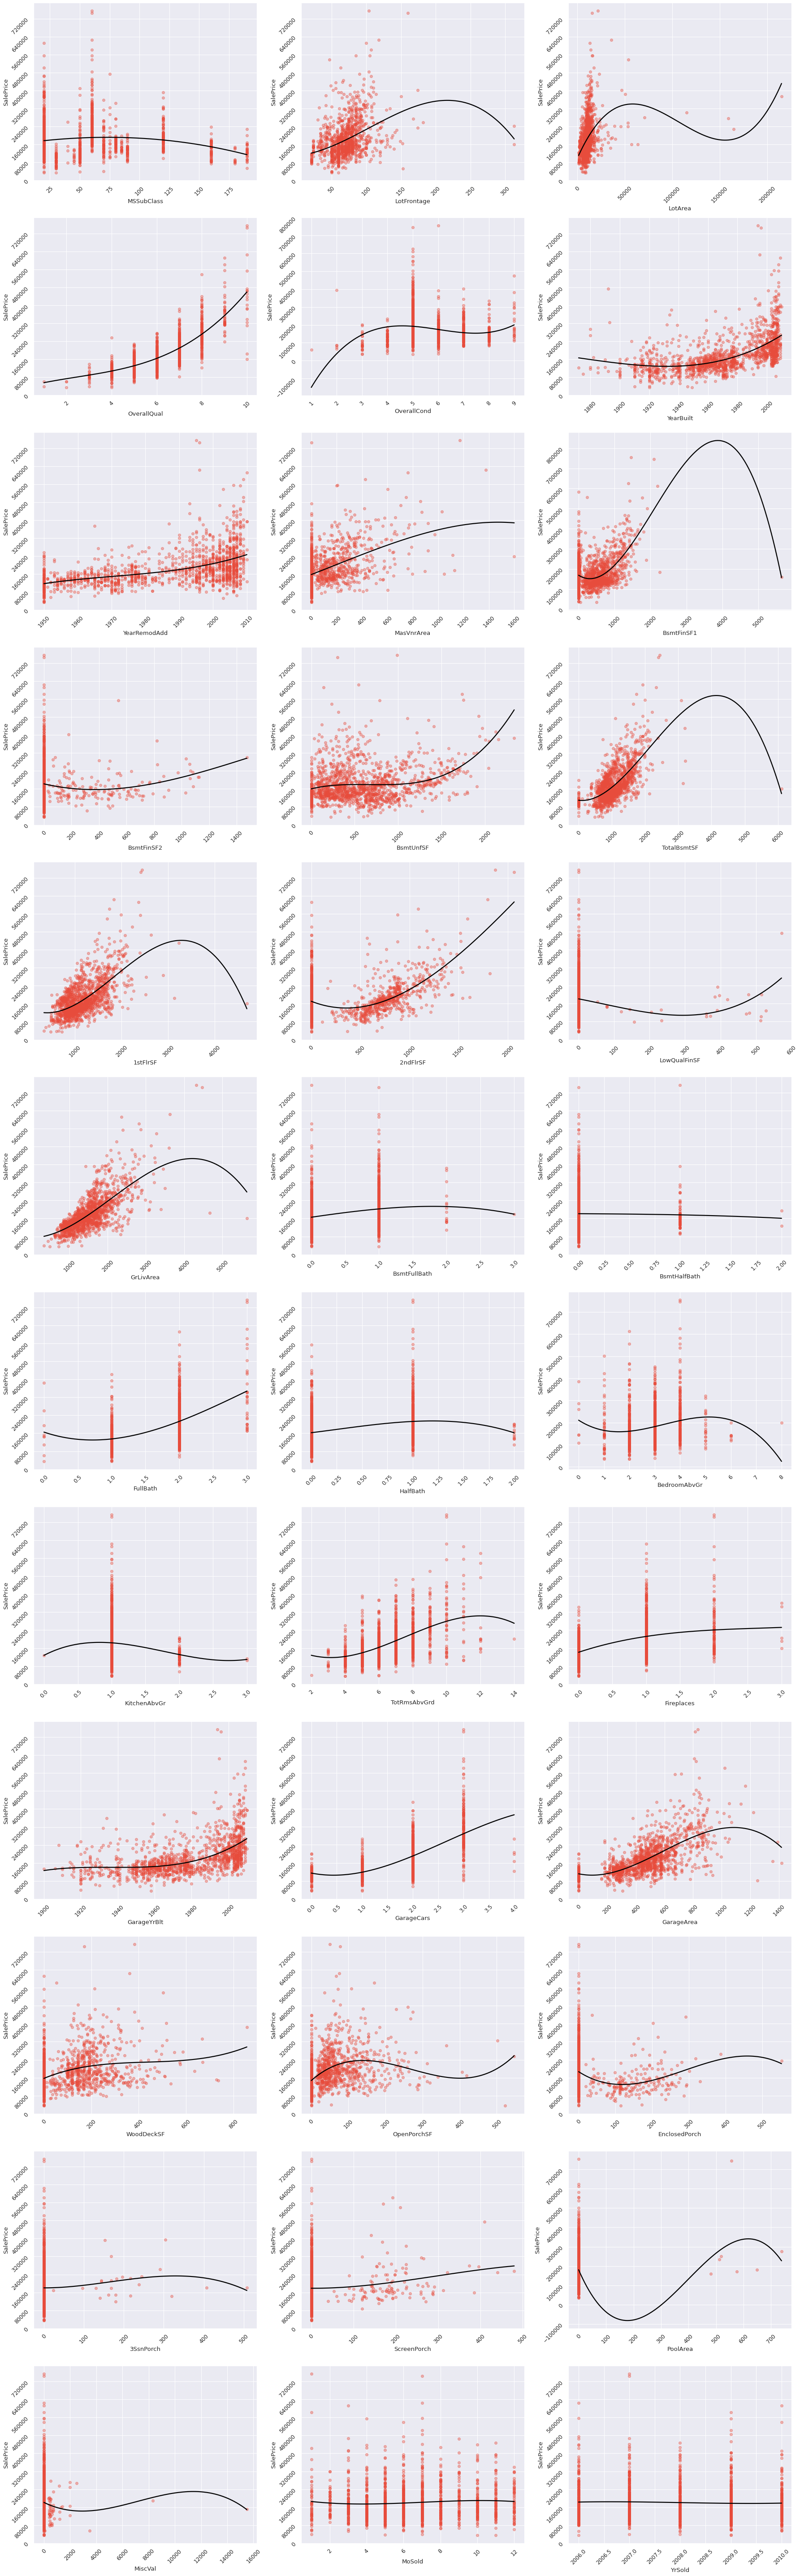

In [26]:
srt_reg('SalePrice', train)

Outliers

Let's drop some outliers detected them just above, this part is kind a subjective and can try different approaches or can implement some automatic outlier detection methods like isolation forests.

In [27]:
# Dropping outliers after detecting them by eye.

features = features.join(y)
features = features.drop(features[(features['OverallQual'] < 5)
                                  & (features['SalePrice'] > 200000)].index)
features = features.drop(features[(features['GrLivArea'] > 4000)
                                  & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['GarageArea'] > 1200)
                                  & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['TotalBsmtSF'] > 3000)
                                  & (features['SalePrice'] > 320000)].index)
features = features.drop(features[(features['1stFlrSF'] < 3000)
                                  & (features['SalePrice'] > 600000)].index)
features = features.drop(features[(features['1stFlrSF'] > 3000)
                                  & (features['SalePrice'] < 200000)].index)

y = features['SalePrice']
y.dropna(inplace=True)
features.drop(columns='SalePrice', inplace=True)

Creating New Features

Let's create some features, these can improve modelling: with basic approach by merging some important indicators and making them stronger.

In [28]:
# Creating new features  based on previous observations. There might be some highly correlated features now. Cab drop them if want to...

features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                       features['1stFlrSF'] + features['2ndFlrSF'])
features['TotalBathrooms'] = (features['FullBath'] +
                              (0.5 * features['HalfBath']) +
                              features['BsmtFullBath'] +
                              (0.5 * features['BsmtHalfBath']))

features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                            features['EnclosedPorch'] +
                            features['ScreenPorch'] + features['WoodDeckSF'])

features['YearBlRm'] = (features['YearBuilt'] + features['YearRemodAdd'])

# Merging quality and conditions.

features['TotalExtQual'] = (features['ExterQual'] + features['ExterCond'])
features['TotalBsmQual'] = (features['BsmtQual'] + features['BsmtCond'] +
                            features['BsmtFinType1'] +
                            features['BsmtFinType2'])
features['TotalGrgQual'] = (features['GarageQual'] + features['GarageCond'])
features['TotalQual'] = features['OverallQual'] + features[
    'TotalExtQual'] + features['TotalBsmQual'] + features[
        'TotalGrgQual'] + features['KitchenQual'] + features['HeatingQC']

# Creating new features by using new quality indicators.

features['QualGr'] = features['TotalQual'] * features['GrLivArea']
features['QualBsm'] = features['TotalBsmQual'] * (features['BsmtFinSF1'] +
                                                  features['BsmtFinSF2'])
features['QualPorch'] = features['TotalExtQual'] * features['TotalPorchSF']
features['QualExt'] = features['TotalExtQual'] * features['MasVnrArea']
features['QualGrg'] = features['TotalGrgQual'] * features['GarageArea']
features['QlLivArea'] = (features['GrLivArea'] -
                         features['LowQualFinSF']) * (features['TotalQual'])
features['QualSFNg'] = features['QualGr'] * features['Neighborhood']

In [29]:
# Observing the effects of newly created features on sale price.

def srt_reg(feature):
    merged = features.join(y)
    fig, axes = plt.subplots(5, 3, figsize=(25, 40))
    axes = axes.flatten()

    new_features = [
        'TotalSF', 'TotalBathrooms', 'TotalPorchSF', 'YearBlRm',
        'TotalExtQual', 'TotalBsmQual', 'TotalGrgQual', 'TotalQual', 'QualGr',
        'QualBsm', 'QualPorch', 'QualExt', 'QualGrg', 'QlLivArea', 'QualSFNg'
    ]

    for i, j in zip(new_features, axes):

        sns.regplot(x=i,
                    y=feature,
                    data=merged,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

Checking New Features

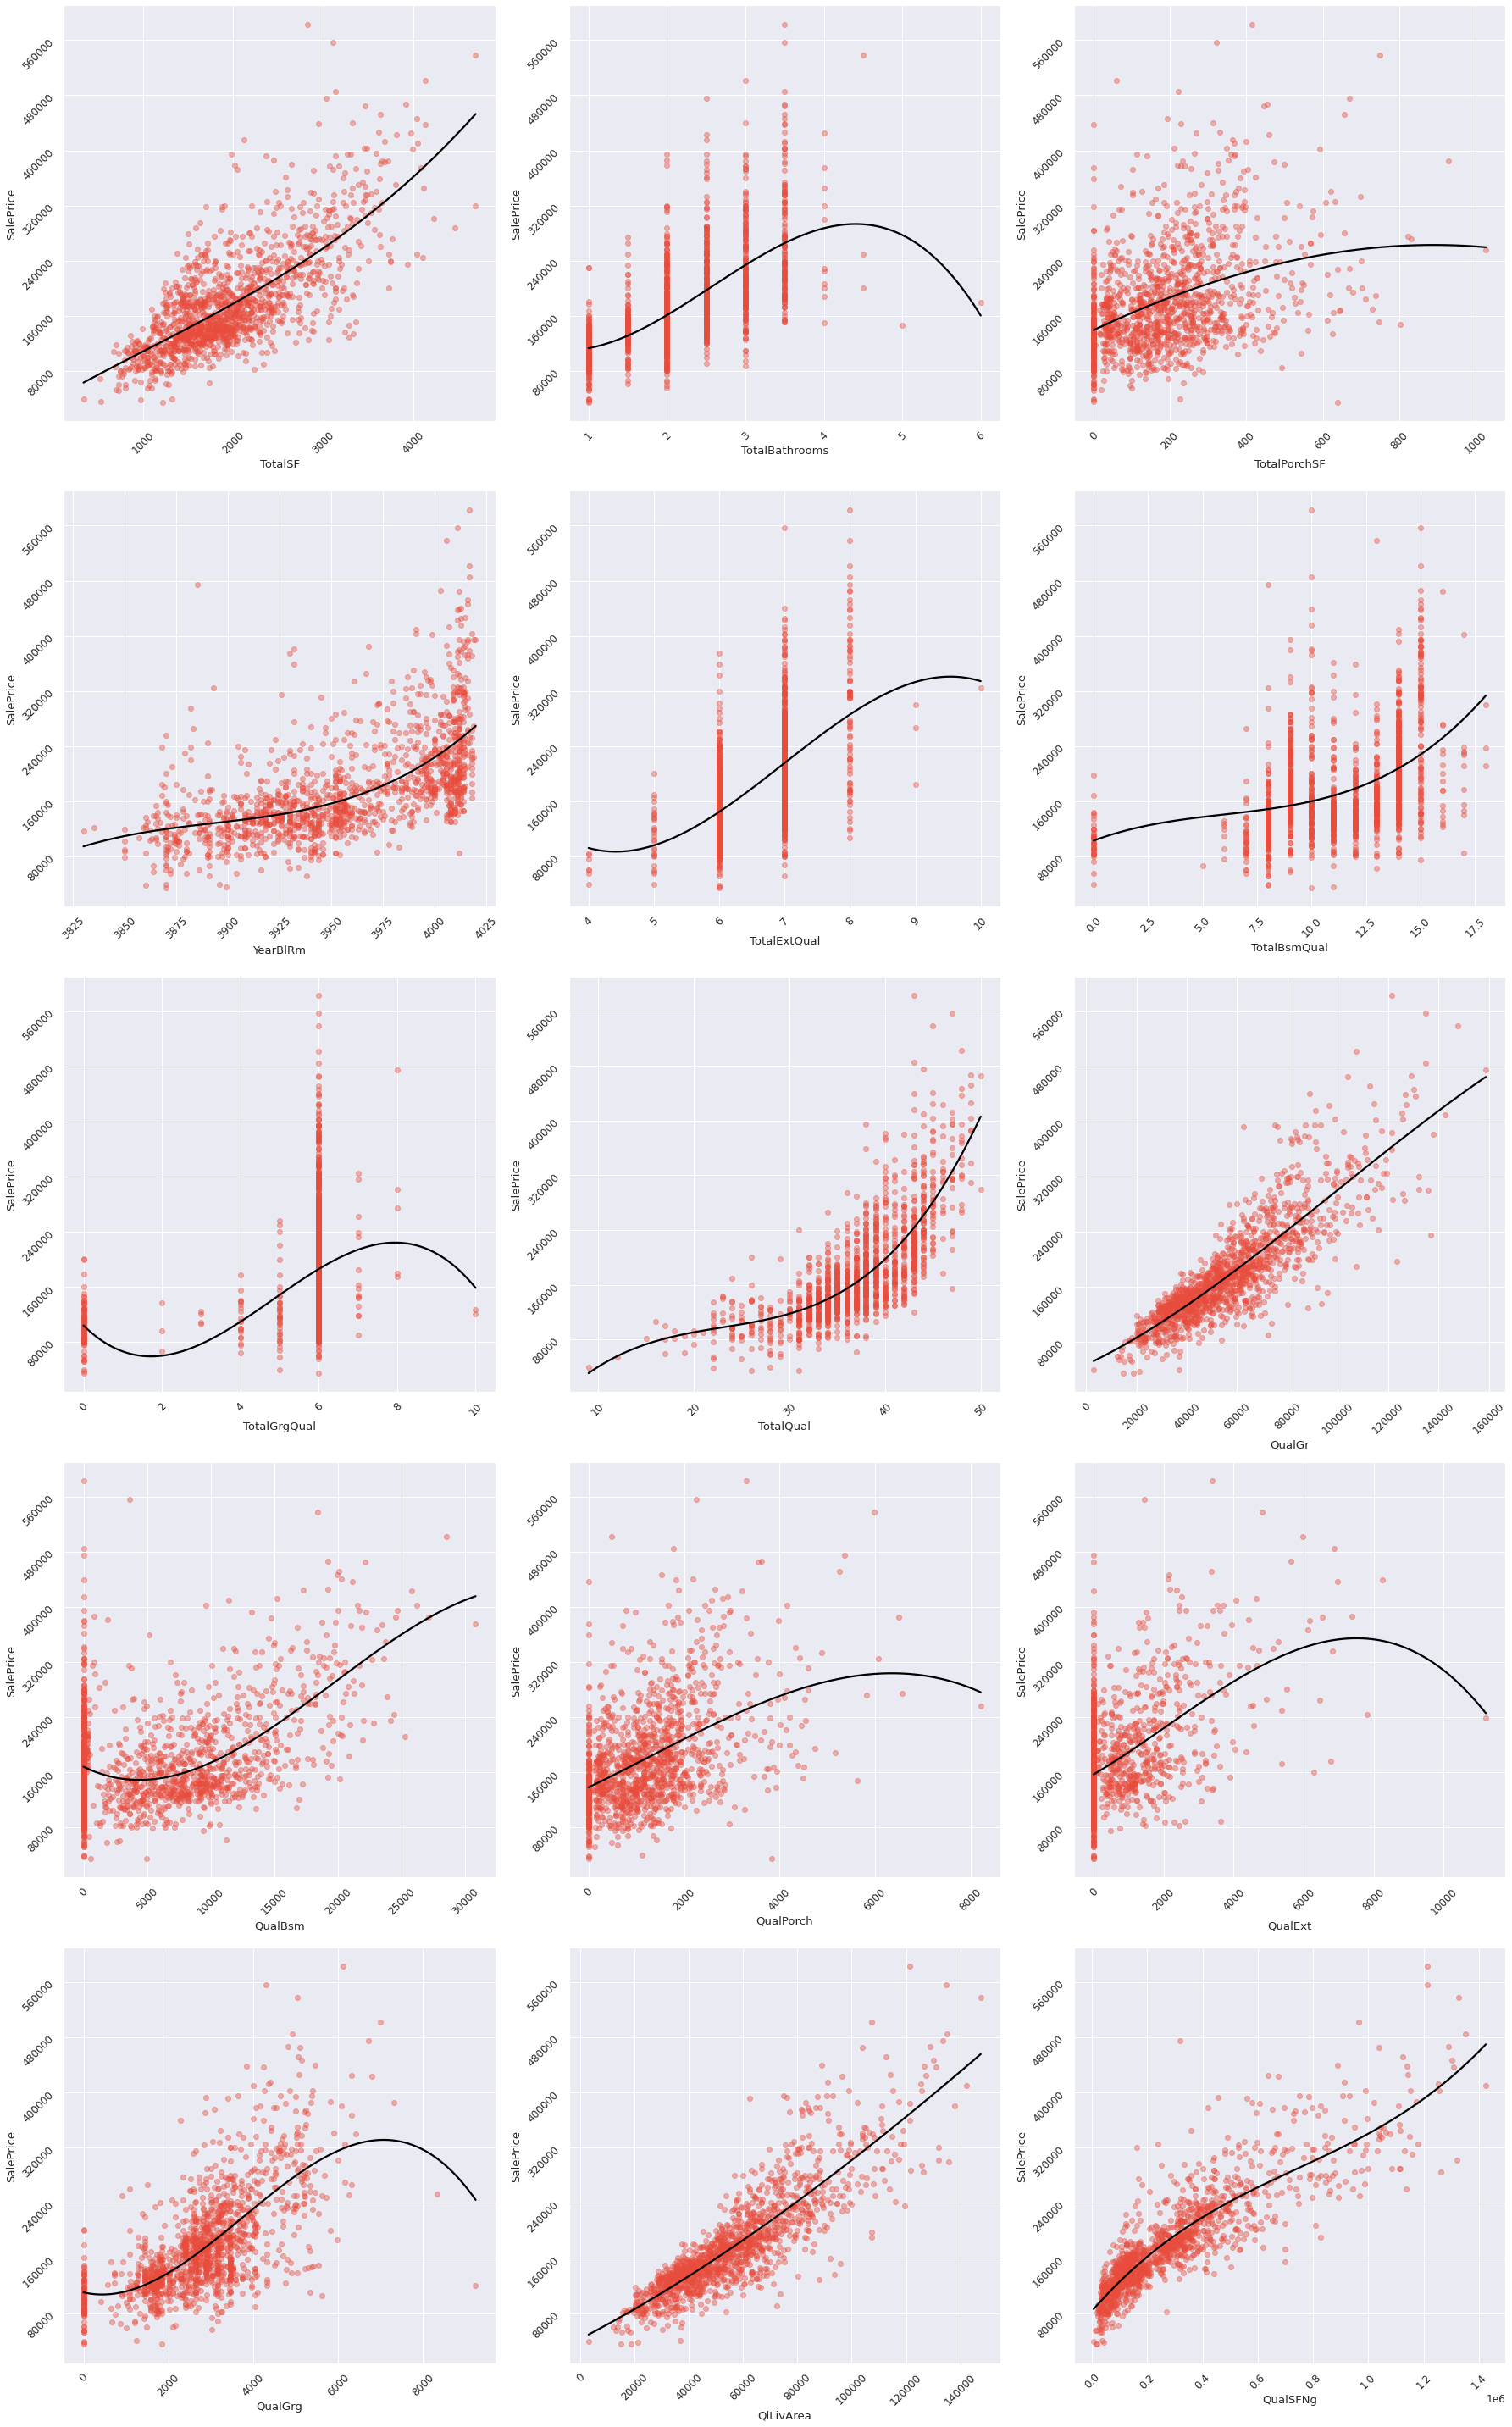

In [30]:
srt_reg('SalePrice')

Add some more basic features for having specific feature or not. This approach was widely accepted by community.

In [31]:
# Creating some simple features.

features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x: 1
                                                     if x > 0 else 0)
features['HasGarage'] = features['QualGrg'].apply(lambda x: 1 if x > 0 else 0)
features['HasBsmt'] = features['QualBsm'].apply(lambda x: 1 if x > 0 else 0)
features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1
                                                        if x > 0 else 0)
features['HasPorch'] = features['QualPorch'].apply(lambda x: 1 if x > 0 else 0)

Transforming the Data

Some of the continious values are not distributed evenly and not fitting on normal distribution, can fix them by using couple transformation approaches. Let's list skewed features and then apply boxcox transformation with boxcox_normmax (It computes optimal boxcox transform parameter for input data, so don't decide the lambda here).

In [32]:
# Numerical features worked on which seems highly skewed but filter again anyways...

skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]

In [33]:
# Finding skewness of the numerical features.

skew_features = np.abs(features[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features.

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew.

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness.

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

Dropping some unnecessary features had their use in feature engineering or not needed at all. It's subjective... Then one hot encode the categorical data left so everything will be prepared for the modelling.

In [34]:
# Features to drop:

to_drop = [
    'Utilities',
    'PoolQC',
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC',
]

# Dropping features.

features.drop(columns=to_drop, inplace=True)

In [35]:
# Getting dummy variables for categorical data.

features = pd.get_dummies(data=features)

New Check

- Before move to modelling, let's take one last look to the data processed. Everyting seems in order, not missing datas, values are numerical etc. Feature engineered data is present...

- Just want to check how transformed data correlates with sale prices before move on and it looks decent.

- Again check target value distribution and it seems little skewed. Can fix this by applying log transformation so models can perform better.

In [36]:
print(f'Number of missing values: {features.isna().sum().sum()}')

Number of missing values: 0


In [37]:
features.shape

(2908, 226)

In [38]:
features.sample(5)

LotFrontage    LotArea  Neighborhood  OverallQual  OverallCond  \
346     19.798846  15.063850             3            6            8   
1556    17.482488  14.463596             3            5            4   
113     19.280169  16.276980             6            6            5   
2171    19.280169  14.297401             5            5            6   
142     19.454042  14.116370             3            5            4   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterCond  BsmtCond  BsmtFinType1  \
346        1960          1998    0.000000          4         3             4   
1556       1915          1950    0.000000          2         3             3   
113        1953          1953   19.214228          4         3             5   
2171       1975          1975   18.813655          3         3             5   
142        1952          1952    0.000000          2         3             3   

      BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
346   114.519313             1    0.000000  59.139223   510.342511  6.359197   
1556  192.109208             1    0.000000  34.294302   629.562859  6.559820   
113    16.523146             3   12.531965  88.425399   900.066756  7.086022   
2171   78.415237             1    0.000000  81.092958   566.105784  6.458415   
142   115.999783             1    0.000000  54.643404   487.450601  6.315211   

        2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
346     0.000000           0.0   8.576725           0.0           0.0   
1556  227.556134           0.0   9.157152           1.0           0.0   
113     0.000000           0.0   9.929969           1.0           0.0   
2171    0.000000           0.0   8.755694           0.0           0.0   
142   632.900242           0.0   9.149229           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
346          1         0             2             1             5   
1556         1         0             3             1             6   
113          2         0             3             1             7   
2171         1         1             3             1             5   
142          2         0             4             1             6   

      Fireplaces  FireplaceQu  GarageYrBlt  GarageCars  GarageArea  \
346            0            0       1960.0         1.0       301.0   
1556           0            0          0.0         0.0         0.0   
113            2            4       1953.0         2.0       450.0   
2171           1            2       1985.0         2.0       576.0   
142            0            0       2000.0         2.0       720.0   

      GarageCond  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
346            3    0.000000     0.000000       0.000000        0.0   
1556           0    0.000000     0.000000      13.275238        0.0   
113            3   38.271306    17.064945      13.998657        0.0   
2171           3    0.000000     0.000000       0.000000        0.0   
142            3    0.000000     0.000000       0.000000        0.0   

      ScreenPorch  PoolArea    MiscVal  TotalSF  TotalBathrooms  TotalPorchSF  \
346           0.0       0.0  10.432746   1456.0             1.0             0   
1556          0.0       0.0   0.000000   2418.0             2.0           168   
113           0.0       0.0   0.000000   3163.0             3.0           478   
2171          0.0       0.0   0.000000   1370.0             1.5             0   
142           0.0       0.0   0.000000   1892.0             2.0             0   

      YearBlRm  TotalExtQual  TotalBsmQual  TotalGrgQual  TotalQual  QualGr  \
346       3958             7            11             6         36   34488   
1556      3865             4            10             0         25   34800   
113       3906             7            15             6         41   92619   
2171      3950             6            12             6         35   37660   
142       3904       

In [39]:
features.describe()

LotFrontage      LotArea  Neighborhood  OverallQual  OverallCond  \
count  2908.000000  2908.000000   2908.000000  2908.000000  2908.000000   
mean     18.932143    14.236979      4.455640     6.081843     5.566713   
std       3.698922     1.155737      2.457431     1.397639     1.114074   
min       8.809473    10.151044      1.000000     1.000000     1.000000   
25%      17.482488    13.809917      3.000000     5.000000     5.000000   
50%      19.280169    14.351060      4.000000     6.000000     5.000000   
75%      20.976651    14.815543      5.000000     7.000000     6.000000   
max      48.749456    22.753416     10.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea    ExterCond     BsmtCond  \
count  2908.000000   2908.000000  2908.000000  2908.000000  2908.000000   
mean   1971.252751   1984.227992     8.183116     3.085282     2.918157   
std      30.296319     20.899483    11.176757     0.372262     0.576014   
min    1872.000000   1950.000000     0.000000     1.000000     0.000000   
25%    1953.000000   1965.000000     0.000000     3.000000     3.000000   
50%    1973.000000   1993.000000     0.000000     3.000000     3.000000   
75%    2001.000000   2004.000000    18.086738     3.000000     3.000000   
max    2010.000000   2010.000000    51.503144     5.000000     4.000000   

       BsmtFinType1   BsmtFinSF1  BsmtFinType2   BsmtFinSF2    BsmtUnfSF  \
count   2908.000000  2908.000000   2908.000000  2908.000000  2908.000000   
mean       3.535420    89.404299      1.273384     1.158782    60.314323   
std        2.113347    79.132830      0.954352     3.241698    32.850282   
min        0.000000     0.000000      0.000000     0.000000     0.000000   
25%        1.000000     0.000000      1.000000     0.000000    37.968112   
50%        4.000000    92.161734      1.000000     0.000000    59.674863   
75%        6.000000   150.796240      1.000000     0.000000    82.392453   
max        6.000000   507.637694      6.000000    14.352604   154.678888   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  2908.000000  2908.000000  2908.000000   2908.000000  2908.000000   
mean    546.849878     6.474137   460.160911      0.062741     9.193287   
std     201.641654     0.272501   590.189455      0.534211     0.505437   
min       0.000000     5.447959     0.000000      0.000000     7.012554   
25%     430.479452     6.282596     0.000000      0.000000     8.824658   
50%     524.586689     6.462370     0.000000      0.000000     9.212684   
75%     669.403427     6.671500   958.401112      0.000000     9.510844   
max    2267.208842     7.762519  2673.776791      5.405398    11.282379   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   2908.000000   2908.000000  2908.000000  2908.000000   2908.000000   
mean       0.427785      0.061210     1.565681     0.379642      2.859697   
std        0.523883      0.245429     0.550340     0.502787      0.822532   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     4.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  FireplaceQu  GarageYrBlt  \
count   2908.000000   2908.000000  2908.000000  2908.000000  2908.000000   
mean       1.044704      6.440509     0.593535     1.761692  1869.897180   
std        0.214850      1.557377     0.642910     1.805455   450.471016   
min        0.000000      2.000000     0.000000     0.000000     0.000000   
25%        1.000000      5.000000     0.000000     0.000000  1957.000000   
50%        1.000000      6.000000     1.000000     1.000000  1977.000000   
75%        1.000000      7.000000     1.000000     4.000000  2001.00

In [40]:
# Separating train and test set.

train = features.iloc[:len(y), :]
test = features.iloc[len(train):, :]

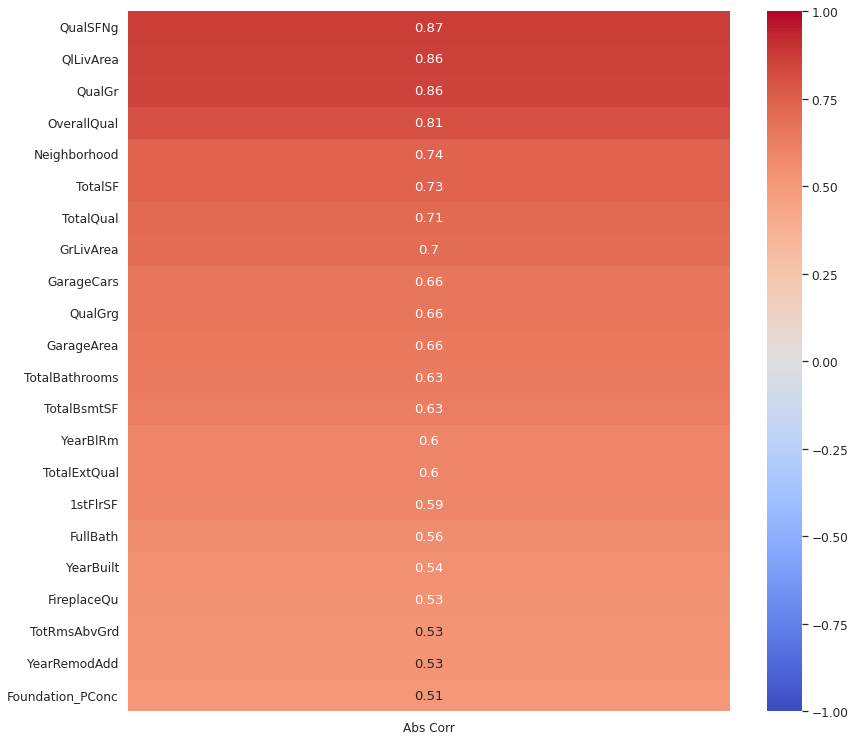

In [41]:
correlations = train.join(y).corrwith(train.join(y)['SalePrice']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.5], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

In [42]:
def plot_dist3(df, feature, title):
    
    # Creating a customized chart. and giving in figsize and everything.
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    # creating a grid of 3 cols and 3 rows.
    
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    
    ax1 = fig.add_subplot(grid[0, :2])
    
    # Set the title.
    
    ax1.set_title('Histogram')
    
    # plot the histogram.
    
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # customizing the QQ_plot.
    
    ax2 = fig.add_subplot(grid[1, :2])
    
    # Set the title.
    
    ax2.set_title('Probability Plot')
    
    # Plotting the QQ_Plot.
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot:
    
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=24)

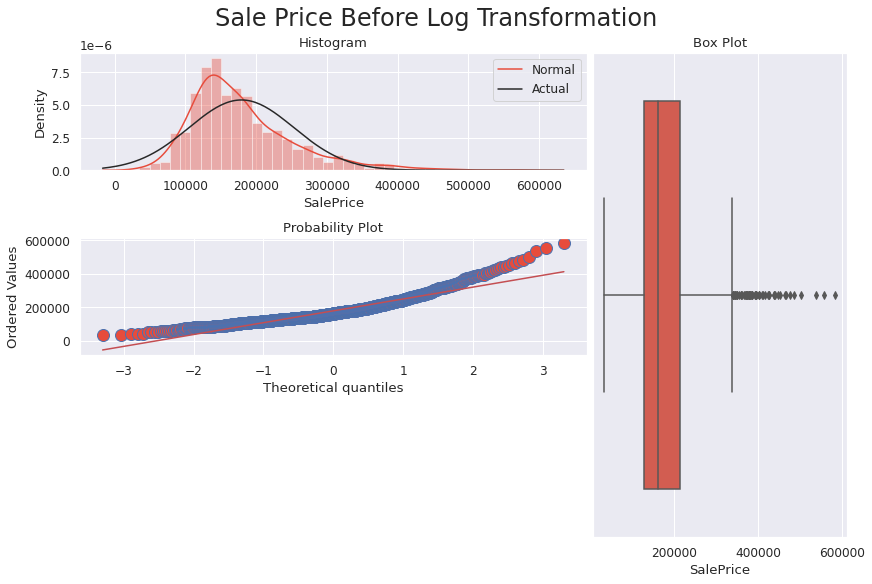

In [43]:
# Checking target variable.

plot_dist3(train.join(y), 'SalePrice', 'Sale Price Before Log Transformation')

In [44]:
# Setting model data.

X = train
X_test = test
y = np.log1p(y)

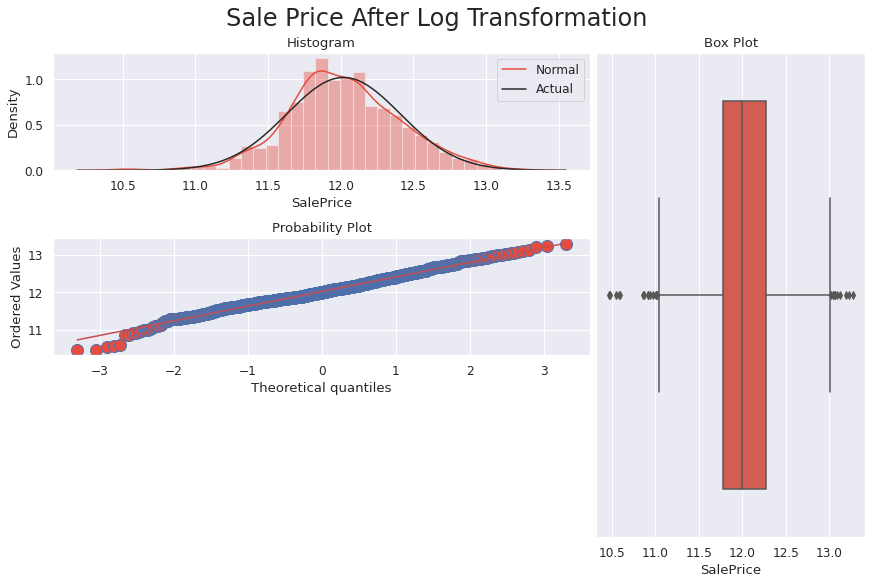

In [45]:
plot_dist3(train.join(y), 'SalePrice', 'Sale Price After Log Transformation')

Modelling

Let's start with loading packages needed and then set regressors. The regressors are:

- Ridge;
- Lasso;
- Elasticnet;
- Support Vector Regression;
- Gradient Boosting Regressor;
- LightGBM Regressor;
- XGBoost Regressor;
- Hist Gradient Boosting Regressor;
- Tweedie Regressor.

In [46]:
# Loading neccesary packages for modelling.

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor # This is for stacking part, works well with sklearn and others...

In [48]:
# Setting kfold for future use.

#kf = KFold(10, random_state=42)
kf = KFold(10, random_state=None)

In [49]:
# Some parameters for ridge, lasso and elasticnet.

alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge_cv

ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

# lasso_cv:

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

# elasticnet_cv:

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=1e7,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio))

# svr:

svr = make_pipeline(RobustScaler(),
                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))

# gradientboosting:

gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

# lightgbm:

lightgbm = LGBMRegressor(objective='regression',
                         n_estimators=3500,
                         num_leaves=5,
                         learning_rate=0.00721,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         n_jobs=-1,
                         bagging_seed=42,
                         feature_fraction_seed=42,
                         bagging_freq=7,
                         feature_fraction=0.1294,
                         min_data_in_leaf=8)

# xgboost:

xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)


# hist gradient boosting regressor:

hgrd= HistGradientBoostingRegressor(    loss= 'least_squares',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225,
                                    random_state=42)

# tweedie regressor:
 
tweed = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))


# stacking regressor:

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                            xgboost, lightgbm,hgrd, tweed),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

Cross Validation

In [50]:
def model_check(X, y, estimators, cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [51]:
# Setting list of estimators and labels for them:

estimators = [ridge, lasso, elasticnet, gbr, xgboost, lightgbm, svr, hgrd, tweed]
labels = [
    'Ridge', 'Lasso', 'Elasticnet', 'GradientBoostingRegressor',
    'XGBRegressor', 'LGBMRegressor', 'SVR', 'HistGradientBoostingRegressor','TweedieRegressor'
]

Model Results

In [52]:
# Executing cross validation.

raw_models = model_check(X, y, estimators, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))

Stacking & Blending

Let's fit every single estimator have on the train data and then blend them by assigning weights to each model and sum the results. Weights are pretty subjective...

In [53]:
# Fitting the models on train data.

print('=' * 20, 'START Fitting', '=' * 20)
print('=' * 55)

print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(X.values, y.values)
print(datetime.now(), 'Elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'Lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'Ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'SVR')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'XGboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'Lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)
print(datetime.now(), 'Hist')
hist_full_data = hgrd.fit(X, y)
print(datetime.now(), 'Tweed')
tweed_full_data = tweed.fit(X, y)
print('=' * 20, 'FINISHED Fitting', '=' * 20)
print('=' * 58)

==================== START Fitting ====================
2022-05-13 00:28:09.376621 StackingCVRegressor
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.35711, su

In [54]:
# Blending models by assigning weights:

def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) +
            (0.1 * lasso_model_full_data.predict(X)) +
            (0.1 * ridge_model_full_data.predict(X)) +
            (0.1 * svr_model_full_data.predict(X)) +
            (0.05 * gbr_model_full_data.predict(X)) +
            (0.1 * xgb_model_full_data.predict(X)) +
            (0.05 * lgb_model_full_data.predict(X)) +
            (0.05 * hist_full_data.predict(X)) +
            (0.1 * tweed_full_data.predict(X)) +
            (0.25 * stack_gen_model.predict(X.values)))

Submission

Models are tuned, stacked, fitted and blended so let's to predict and submit results.

In [55]:
submission = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
# Inversing and flooring log scaled sale price predictions
submission['SalePrice'] = np.floor(np.expm1(blend_models_predict(X_test)))
# Defining outlier quartile ranges
q1 = submission['SalePrice'].quantile(0.0050)
q2 = submission['SalePrice'].quantile(0.99)

# Applying weights to outlier ranges to smooth them
submission['SalePrice'] = submission['SalePrice'].apply(
    lambda x: x if x > q1 else x * 0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x
                                                        if x < q2 else x * 1.1)
submission = submission[['Id', 'SalePrice']]

In [56]:
# Saving submission file

submission.to_csv('mysubmission.csv', index=False)
print(
    'Save submission',
    datetime.now(),
)
submission.head()

Save submission 2022-05-13 00:37:31.877860


Id  SalePrice
0  1461   117077.0
1  1462   158438.0
2  1463   188269.0
3  1464   196954.0
4  1465   187491.0

References:

- <https://www.kaggle.com/code/datafan07/top-1-approach-eda-new-models-and-stacking/notebook> (special thanks to ERTUĞRUL DEMIR);
- <https://www.kaggle.com/code/donaldst/stackingandensembling/notebook>;
- <https://www.kaggle.com/code/itslek/stack-blend-lrs-xgb-lgb-house-prices-k-v17/script>.